# Avito Deal Prediction: Stage 1v0 Model
This Stage 1 model features a cascade of regressors: each one focusing on a pre-selected range of **image_top_1** features. The split points for the pre-selected ranges were determined in the Stage 1 Data Exploration notebook. As in the Stage 0 Model, Light GBM will be used to create the regression model.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

import lightgbm as lgb

## Helper Functions:

In [2]:
def make_submission(test_predictions, item_id_list, csv_path):
    test_predictions = np.clip(test_predictions,0,1)
    rows = np.stack((item_id_list, test_predictions)).T
    df = pd.DataFrame(columns=['item_id', 'deal_probability'], data=rows)
    df.to_csv(csv_path, index=False)
    return None

In [3]:
def run_training(sname, params, num_boost, vnum, train, labels, test):
    print 'Start training on %s'%sname
    # Create train, val, test splits
    train_df, val_df, train_label_df, val_label_df = train_test_split(train, labels, test_size=0.2, random_state=0)
    # Format for LightGBM training
    d_train = lgb.Dataset(train_df, label=train_label_df)
    d_val = lgb.Dataset(val_df, label=val_label_df)
    
    # Train model
    evals_result = {}  # Record results for plotting
    lgbm = lgb.train(params, d_train, num_boost_round=num_boost, valid_sets=[d_val], evals_result=evals_result, 
                     verbose_eval=vnum)
    
    # Get predictions
    train_pred = lgbm.predict(train)
    test_pred=lgbm.predict(test)
    
    # Make plots
    ax = lgb.plot_metric(evals_result, metric=params['metric'], figsize=(12, 7), grid=False)
    plt.show()
    ax = lgb.plot_importance(lgbm, max_num_features=10, figsize=(12, 7), grid=False)
    plt.show()
    
    return train_pred, test_pred

## General Setup

In [4]:
# Load parameters file
with open('setup_param.json', 'r') as handle:
    setup_params = json.load(handle)

In [5]:
parent_path = setup_params['parent_dir']
data_path = setup_params['data_dir']
scripts_path = setup_params['scripts_dir']
train_csv_path = setup_params['train_csv']
test_csv_path = setup_params['test_csv']

# Light GBM parameters
model_path_1 = setup_params['model_dir_1']

# Training and test sets
labels_path = setup_params['train_labels']
train_data_path = setup_params['stage0_train']

test_data_path = setup_params['stage0_test']
test_items_path = setup_params['test_items']

In [6]:
# Submission path
submission_path = model_path_1 + 'cascade_submission' + ".csv"

## Loading Training and Test Data:

In [7]:
features_list = ['population', 'area', 'latitude', 'longitude', 'density', 'pcn_0',\
                 'pcn_1', 'pcn_2', 'pcn_3', 'pcn_4', 'pcn_5', 'pcn_6', 'pcn_7',\
                 'pcn_8', 'title_count', 'desc_count', 'usetyp_0', 'usetyp_1',\
                 'usetyp_2', 'price', 'image_top_1']
label_name = 'deal_probability'

In [8]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

dropped_features = [x for x in train_df.columns.values if x not in features_list]
# Drop features (if any)
train_df.drop(labels=dropped_features, axis=1, inplace=True)
test_df.drop(labels=dropped_features, axis=1, inplace=True)

In [9]:
if label_name == 'deal_probability':
    label_csv = pd.read_csv(labels_path)
    label_csv = label_csv.deal_prob.values
else:
    label_csv = np.asarray(train[label_name])

In [10]:
# Standardize data
sc = StandardScaler()
train = sc.fit_transform(train_df)
test = sc.transform(test_df)
# Reformat into pandas dataframe
train = pd.DataFrame(data=train, columns=features_list)
test = pd.DataFrame(data=test, columns=features_list)

## Regressor Cascade:

In [11]:
imgtop_train = train_df.image_top_1.values
imgtop_test = test_df.image_top_1.values
imgtop_combined = np.concatenate((imgtop_train, imgtop_test), axis=0)

# Split points
split_val = [np.amin(imgtop_combined), 250, 2000, 2500, np.amax(imgtop_combined)+1]

# Initialize empty predictions
train_pred = np.zeros(len(imgtop_train))
test_pred = np.zeros(len(imgtop_test))

Start training on stage0
[40]	valid_0's rmse: 0.186171
[80]	valid_0's rmse: 0.185409
[120]	valid_0's rmse: 0.184887
[160]	valid_0's rmse: 0.184442
[200]	valid_0's rmse: 0.18416
[240]	valid_0's rmse: 0.18397
[280]	valid_0's rmse: 0.183834
[320]	valid_0's rmse: 0.18371
[360]	valid_0's rmse: 0.183632
[400]	valid_0's rmse: 0.183564


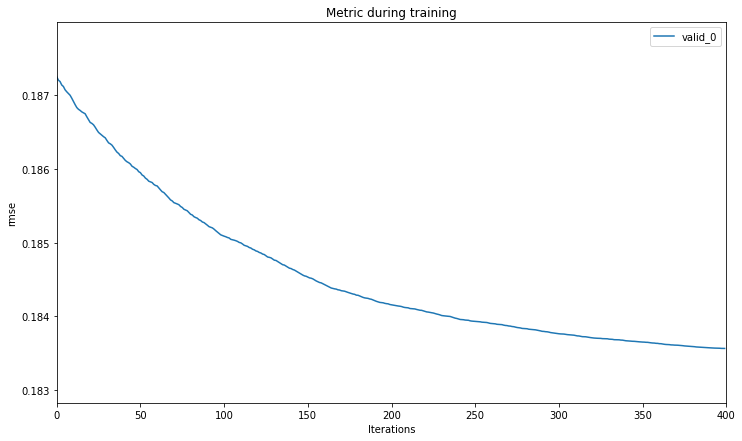

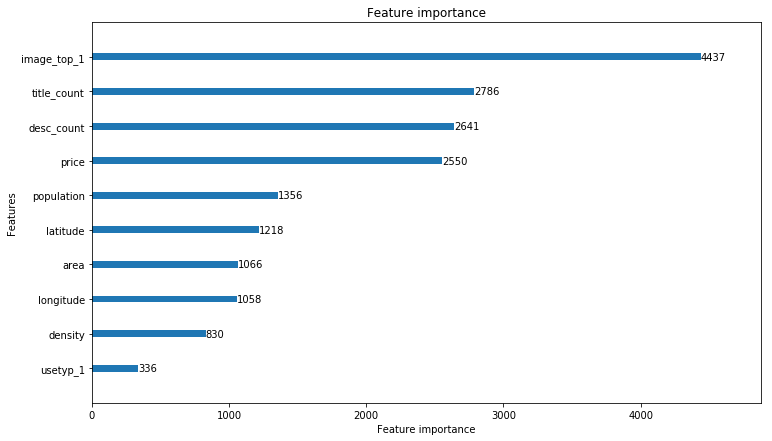

Training error: 0.18271041004637056


In [12]:
# Step 0
i = 0
stage_name = 'stage%s'%i

# Parameters
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['num_leaves'] = 50
params['feature_fraction'] = .6
params['bagging_fraction'] = .8
n_boost = 400
v_num = n_boost/10

# Find indexes
train_idx = train_df.loc[(train_df.image_top_1 >= split_val[i]) & (train_df.image_top_1 < split_val[i+1])].index
test_idx = test_df.loc[(test_df.image_top_1 >= split_val[i]) & (test_df.image_top_1 < split_val[i+1])].index
# Get training and test segments
input_train = train.iloc[train_idx]
input_label = label_csv[train_idx]
input_test = test.iloc[test_idx]

trainpred, testpred = run_training(stage_name, params, n_boost, v_num, input_train, input_label, input_test)
# Evalulate training error
print 'Training error:', np.sqrt(mean_squared_error(y_pred=trainpred, y_true=input_label))

# Append to training and test predictions
train_pred[train_idx] = trainpred
test_pred[test_idx] = testpred

Start training on stage1
[60]	valid_0's rmse: 0.236187
[120]	valid_0's rmse: 0.233644
[180]	valid_0's rmse: 0.232715
[240]	valid_0's rmse: 0.232356
[300]	valid_0's rmse: 0.232068
[360]	valid_0's rmse: 0.23189
[420]	valid_0's rmse: 0.231755
[480]	valid_0's rmse: 0.231653
[540]	valid_0's rmse: 0.231587
[600]	valid_0's rmse: 0.231498


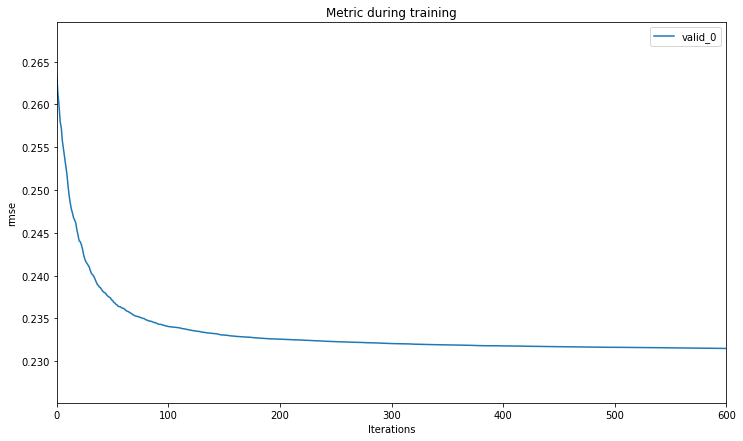

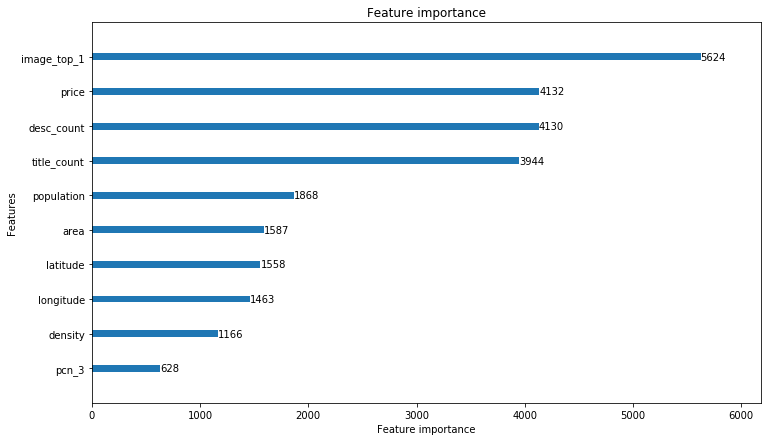

Training error: 0.22886002527972885


In [13]:
# Step 1
i = 1
stage_name = 'stage%s'%i

# Parameters
params = {}
params['learning_rate'] = 0.05
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['num_leaves'] = 50
params['feature_fraction'] = .6
params['bagging_fraction'] = .8
n_boost = 600
v_num = n_boost/10

# Find indexes
train_idx = train_df.loc[(train_df.image_top_1 >= split_val[i]) & (train_df.image_top_1 < split_val[i+1])].index
test_idx = test_df.loc[(test_df.image_top_1 >= split_val[i]) & (test_df.image_top_1 < split_val[i+1])].index
# Get training and test segments
input_train = train.iloc[train_idx]
input_label = label_csv[train_idx]
input_test = test.iloc[test_idx]

trainpred, testpred = run_training(stage_name, params, n_boost, v_num, input_train, input_label, input_test)
# Evalulate training error
print 'Training error:', np.sqrt(mean_squared_error(y_pred=trainpred, y_true=input_label))

# Append to training and test predictions
train_pred[train_idx] = trainpred
test_pred[test_idx] = testpred

Start training on stage2
[80]	valid_0's rmse: 0.263098
[160]	valid_0's rmse: 0.255141
[240]	valid_0's rmse: 0.250492
[320]	valid_0's rmse: 0.247679
[400]	valid_0's rmse: 0.245829
[480]	valid_0's rmse: 0.244521
[560]	valid_0's rmse: 0.243699
[640]	valid_0's rmse: 0.243108
[720]	valid_0's rmse: 0.242664
[800]	valid_0's rmse: 0.242328


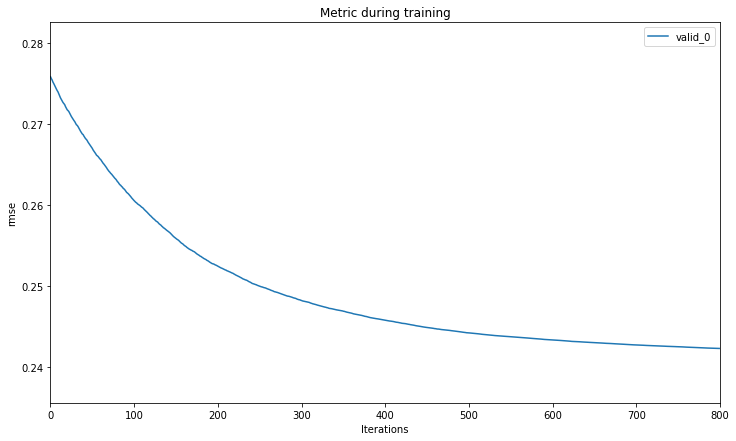

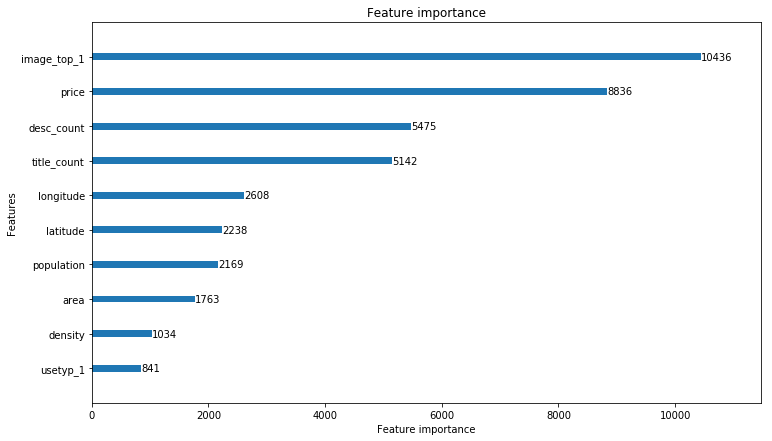

Training error: 0.24200004854063933


In [14]:
# Step 2
i = 2
stage_name = 'stage%s'%i

# Parameters
params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['num_leaves'] = 60
params['feature_fraction'] = .6
params['bagging_fraction'] = .8
n_boost = 800
v_num = n_boost/10

# Find indexes
train_idx = train_df.loc[(train_df.image_top_1 >= split_val[i]) & (train_df.image_top_1 < split_val[i+1])].index
test_idx = test_df.loc[(test_df.image_top_1 >= split_val[i]) & (test_df.image_top_1 < split_val[i+1])].index
# Get training and test segments
input_train = train.iloc[train_idx]
input_label = label_csv[train_idx]
input_test = test.iloc[test_idx]

trainpred, testpred = run_training(stage_name, params, n_boost, v_num, input_train, input_label, input_test)
# Evalulate training error
print 'Training error:', np.sqrt(mean_squared_error(y_pred=trainpred, y_true=input_label))

# Append to training and test predictions
train_pred[train_idx] = trainpred
test_pred[test_idx] = testpred

Start training on stage3
[50]	valid_0's rmse: 0.274637
[100]	valid_0's rmse: 0.270926
[150]	valid_0's rmse: 0.268866
[200]	valid_0's rmse: 0.267653
[250]	valid_0's rmse: 0.266815
[300]	valid_0's rmse: 0.266189
[350]	valid_0's rmse: 0.265777
[400]	valid_0's rmse: 0.265386
[450]	valid_0's rmse: 0.265085
[500]	valid_0's rmse: 0.264861


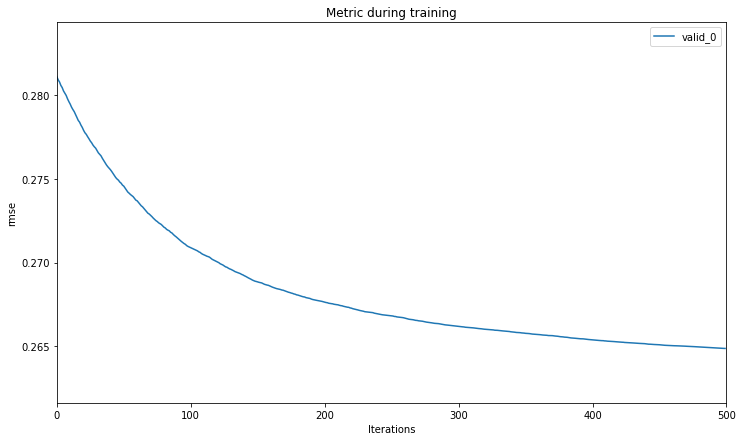

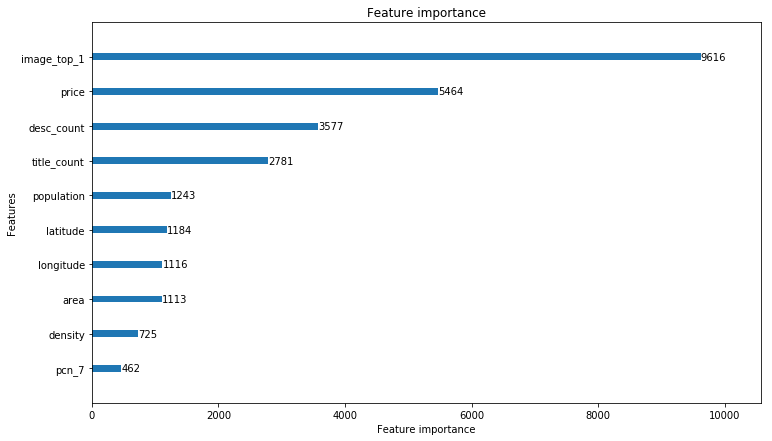

Training error: 0.26329595899216734


In [15]:
# Step 3
i = 3
stage_name = 'stage%s'%i

# Parameters
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['num_leaves'] = 60
params['feature_fraction'] = .8
params['bagging_fraction'] = .8
n_boost = 500
v_num = n_boost/10

# Find indexes
train_idx = train_df.loc[(train_df.image_top_1 >= split_val[i]) & (train_df.image_top_1 < split_val[i+1])].index
test_idx = test_df.loc[(test_df.image_top_1 >= split_val[i]) & (test_df.image_top_1 < split_val[i+1])].index
# Get training and test segments
input_train = train.iloc[train_idx]
input_label = label_csv[train_idx]
input_test = test.iloc[test_idx]

trainpred, testpred = run_training(stage_name, params, n_boost, v_num, input_train, input_label, input_test)
# Evalulate training error
print 'Training error:', np.sqrt(mean_squared_error(y_pred=trainpred, y_true=input_label))

# Append to training and test predictions
train_pred[train_idx] = trainpred
test_pred[test_idx] = testpred

In [16]:
# Evaluate training error
print 'Training error:', np.sqrt(mean_squared_error(y_pred=train_pred, y_true=label_csv))

Training error: 0.22801133142137336


In [17]:
# Make submission script
with open(test_items_path, 'rb') as handle:
    test_item_id = pickle.load(handle)
make_submission(test_pred, test_item_id, submission_path)